In [1]:
initialized = False

# We will use GLOW to learn to generate faces

In [2]:
import os
if(initialized == False):
    os.chdir('..')
    initialized = True

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# os.environ["XLA_FLAGS"] = "--xla_dump_to=/home/eddie/NuX/dump"

In [5]:
import src.flows as nux
import haiku as hk
import jax
from jax import random, vmap, jit
import jax.numpy as jnp
from jax.experimental import optimizers
import tensorflow_datasets as tfds
import tensorflow as tf
import tqdm
from functools import partial
import src.util as util
import matplotlib.pyplot as plt

In [6]:
jax.config.update('jax_log_compiles', True)

# Create a GLOW network

In [7]:
class ConvBlock(hk.Module):

    # nux.Coupling expects an uninitialized Haiku network that accepts an output_shape
    def __init__(self, out_shape, n_hidden_channels=256, name=None):
        _, _, out_channels = out_shape
        super().__init__(name=name)
        self.out_channels = out_channels
        self.n_hidden_channels = n_hidden_channels

        self.last_channels = 2*out_channels

    def __call__(self, x, **kwargs):
        H, W, C = x.shape

        x = hk.Conv2D(output_channels=self.n_hidden_channels, kernel_shape=(3, 3), stride=(1, 1))(x[None])[0]
        x = jax.nn.relu(x)
        x = hk.Conv2D(output_channels=self.n_hidden_channels, kernel_shape=(1, 1), stride=(1, 1))(x[None])[0]
        x = jax.nn.relu(x)
        x = hk.Conv2D(output_channels=self.last_channels, kernel_shape=(3, 3), stride=(1, 1))(x[None])[0]

        mu, alpha = jnp.split(x, 2, axis=-1)
        alpha = jnp.tanh(alpha)
        return mu, alpha

def GLOWBlock(name):
    return nux.sequential(nux.ActNorm(name='an_%s'%name),
                          nux.OnebyOneConvLAX(),
                          nux.Coupling(ConvBlock))

def GLOW(i, num_blocks=1):
    base_idx = i*num_blocks
    layers = [GLOWBlock('glow_%d'%(base_idx + j)) for j in range(num_blocks)]
    return nux.sequential(*layers)

def MultiscaleGLOW(quantize_bits=3):

    flow = nux.Identity()
    flow = nux.multi_scale(GLOW(0), flow)

    flow = nux.sequential(nux.UniformDequantization(scale=2**quantize_bits),
                          nux.Logit(),
                          nux.Squeeze(), # So that the channel is divisible by 2
                          flow,
                          nux.Flatten(),
                          nux.UnitGaussianPrior())
    return flow

# Load the dataset

In [8]:
def central_crop(x):
    x['image'] = x['image'][::2,::2][26:-19,12:-13]
    return x

def quantize(x, quantize_bits):
    quantize_factor = 256/(2**quantize_bits)
    x['image'] = x['image']//tf.cast(quantize_factor, dtype=tf.uint8)
    return x

def load_dataset(split='train', is_training=True, batch_size=32, quantize_bits=3):
    ds = tfds.load('celeb_a', split=split).repeat()
    ds = ds.map(central_crop)
    ds = ds.map(partial(quantize, quantize_bits=quantize_bits))
    if is_training:
        ds = ds.shuffle(10*batch_size, seed=0)
    ds = ds.batch(batch_size)
    return tfds.as_numpy(ds)

# Initialize the model

In [9]:
ds = load_dataset(quantize_bits=3)

x = next(ds)['image']*1.0
inputs = {'x': x}

key = random.PRNGKey(0)
quantize_bits = 3
init_fun = MultiscaleGLOW()
_, flow = init_fun(key, inputs, batched=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
apply_fun = jit(flow.apply)

In [11]:
x = next(ds)['image']*1.0
inputs = {'x': x}
_ = apply_fun(flow.params, flow.state, inputs)

In [12]:
x = next(ds)['image']*1.0
inputs = {'x': x}
_ = apply_fun(flow.params, flow.state, inputs)

In [13]:
params = jax.tree_util.tree_map(lambda x:x*1.01, flow.params)
state = jax.tree_util.tree_map(lambda x:x*1.01, flow.state)

In [14]:
x = next(ds)['image']*1.0
inputs = {'x': x}
_ = apply_fun(params, state, inputs)

# Create the loss function

In [15]:
@partial(jit, static_argnums=(0,))
def nll(apply, params, state, inputs, **kwargs):
    outputs, updated_state = apply(params, state, inputs, **kwargs)
    log_px = outputs['log_det']
    return -jnp.mean(log_px), updated_state

In [16]:
valgrad = jax.value_and_grad(partial(nll, flow.apply), has_aux=True)
valgrad = jit(valgrad)

# Create the optimizer

In [17]:
def lr_schedule(i, warmup=100, lr_decay=1.0, lr=1e-4):
    return jnp.where(i < warmup,
                     lr*i/warmup,
                     lr*(lr_decay**(i - warmup)))

opt_init, opt_update, get_params = optimizers.adam(lr_schedule)
opt_update = jit(opt_update)
get_params = jit(get_params)
opt_state = opt_init(flow.params)
state = flow.state

# Train

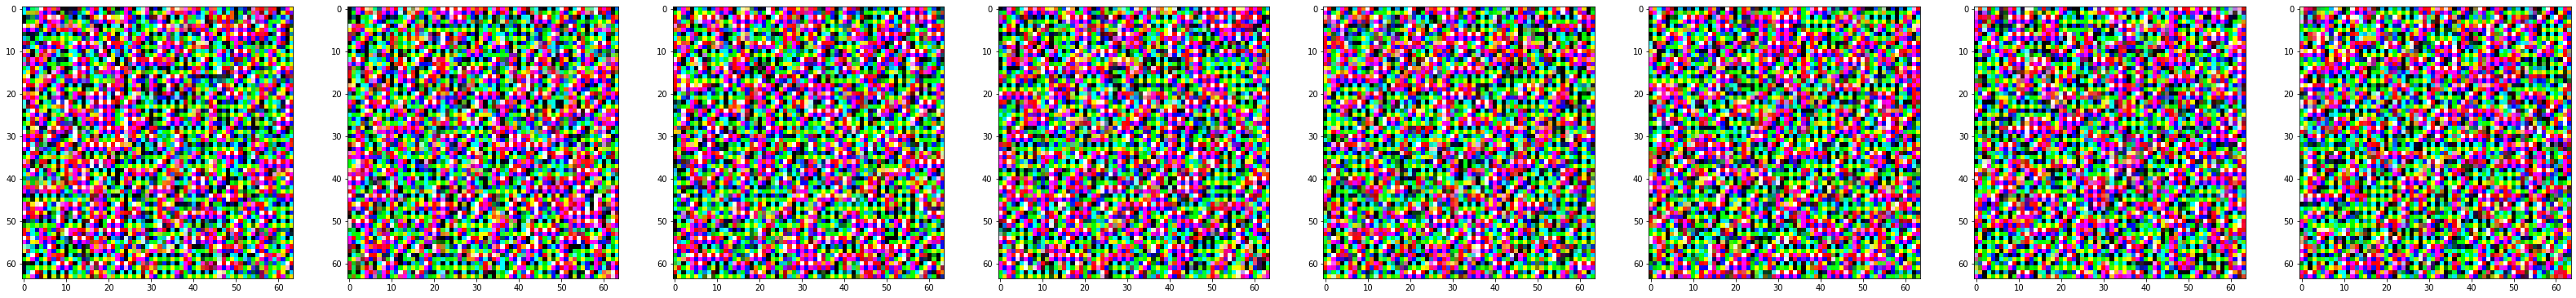

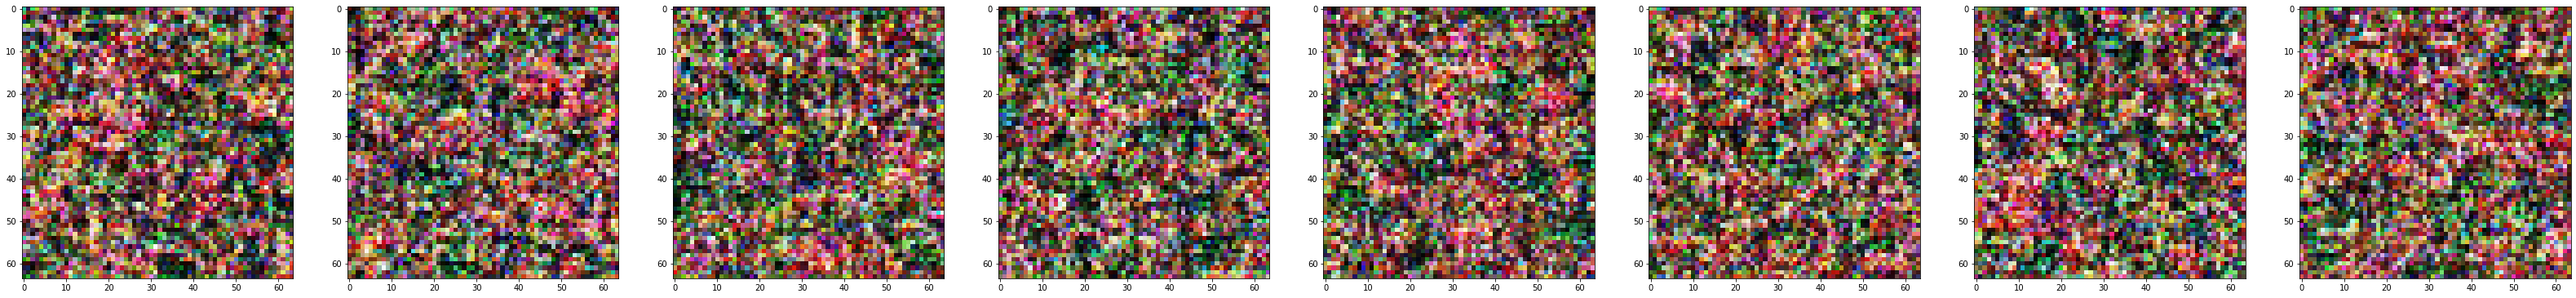

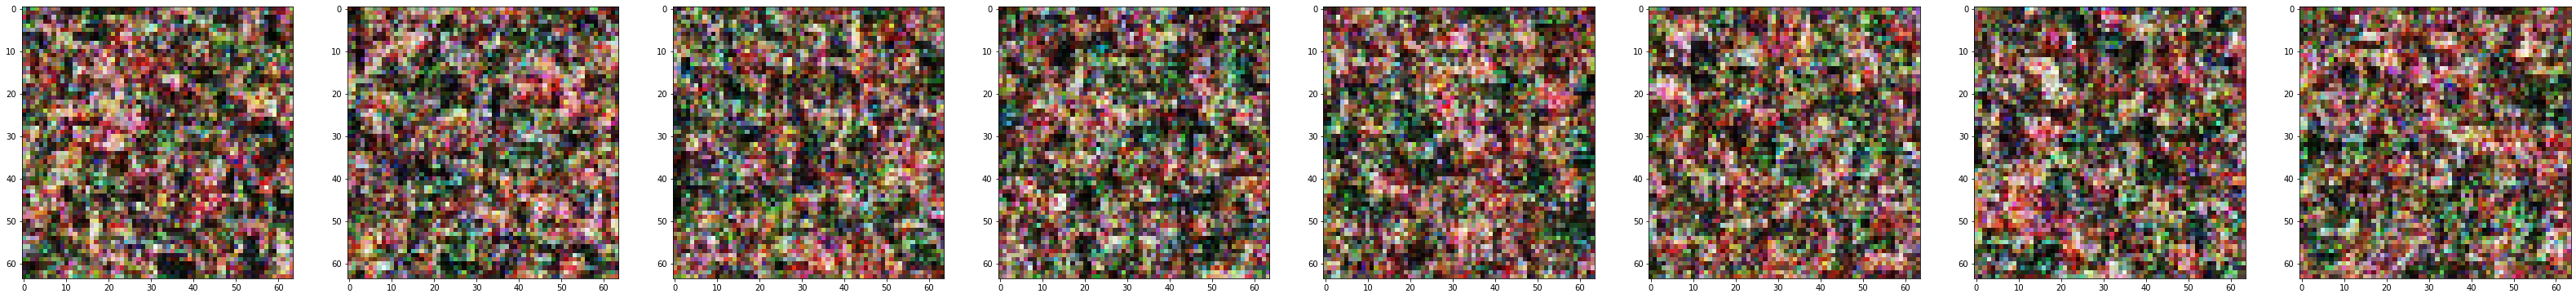

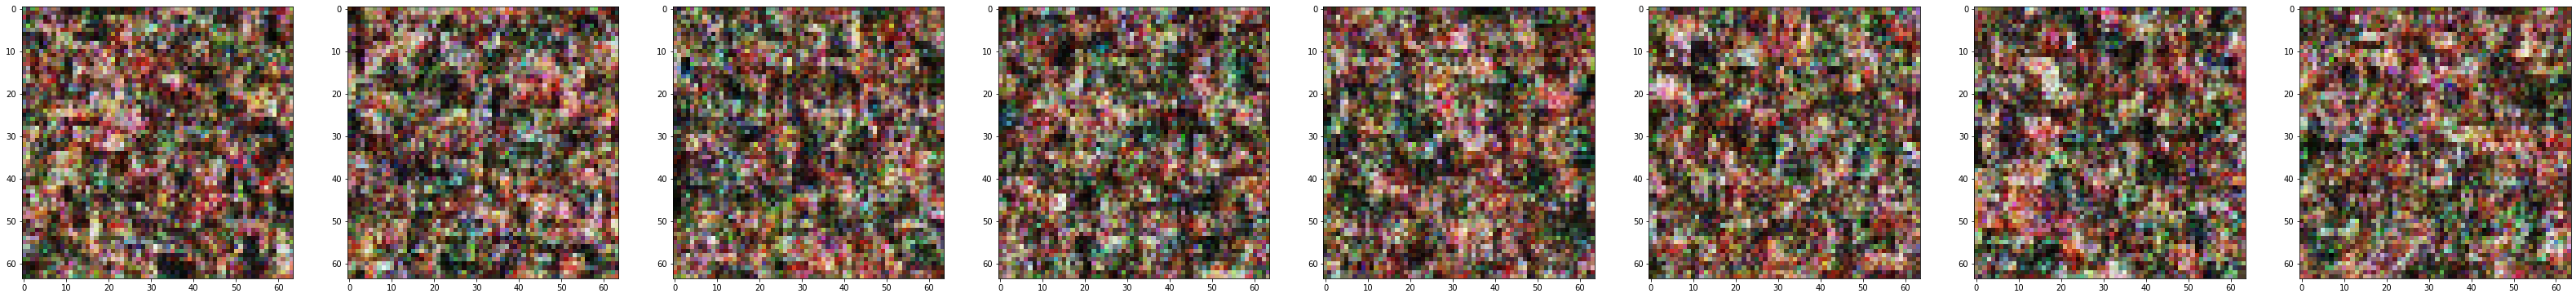

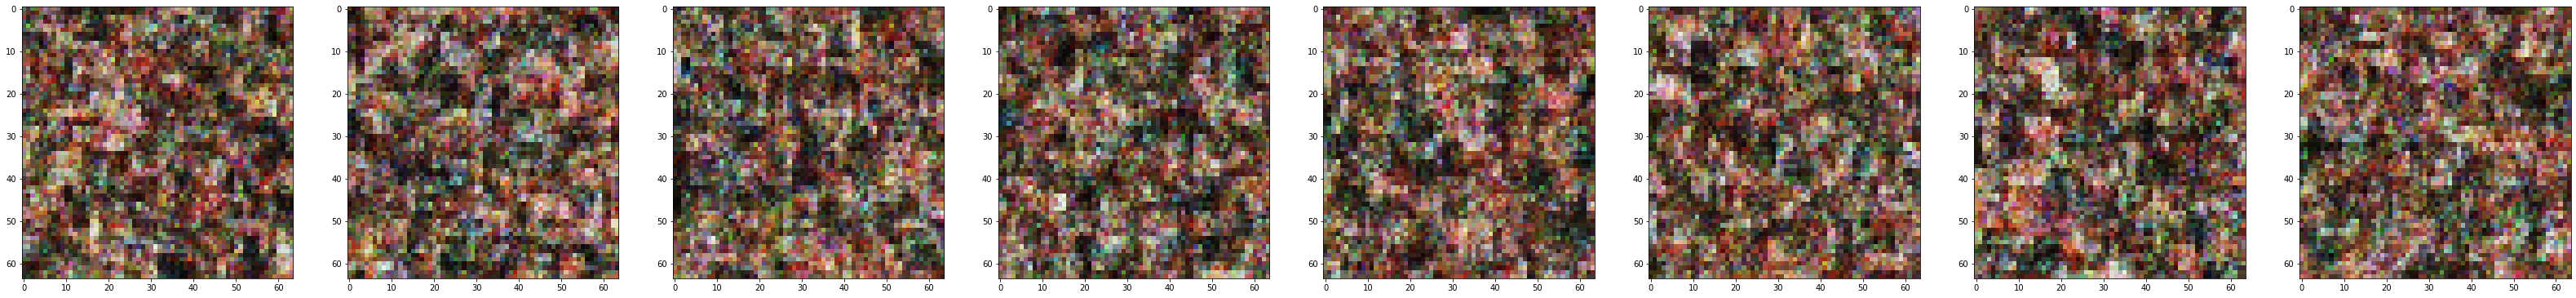

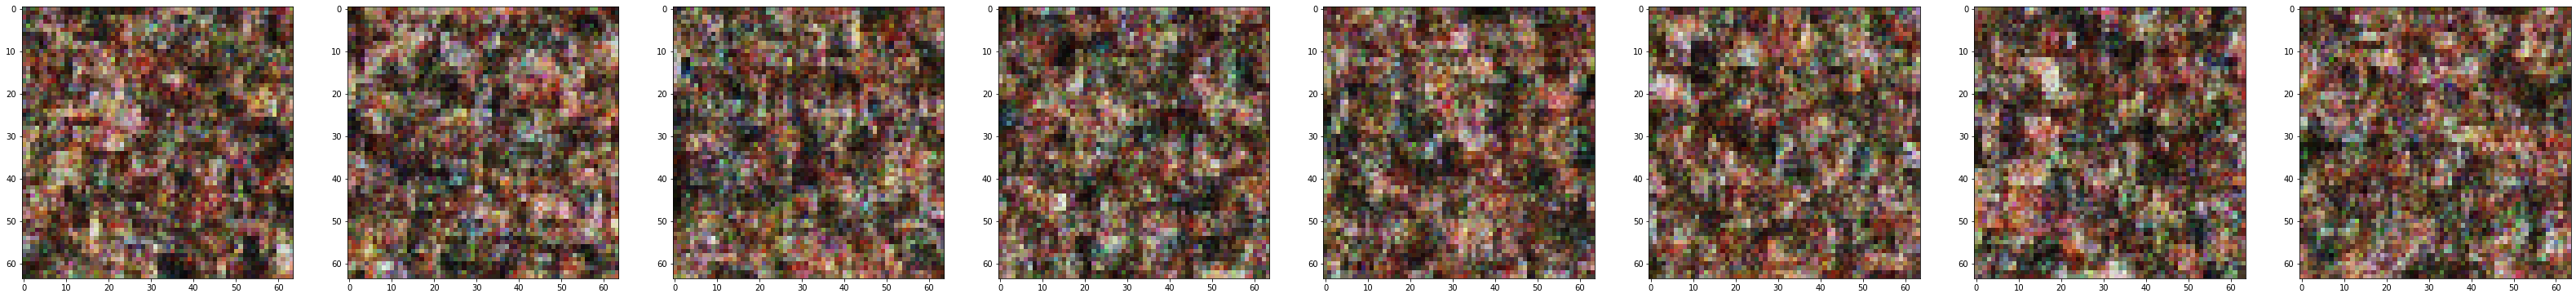

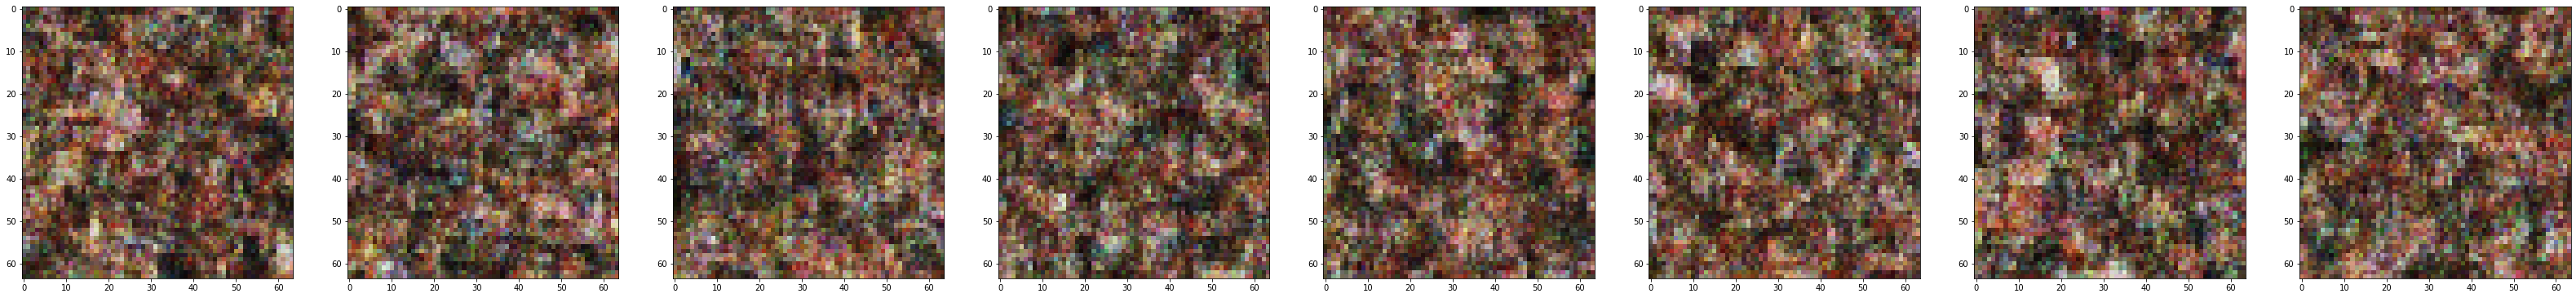

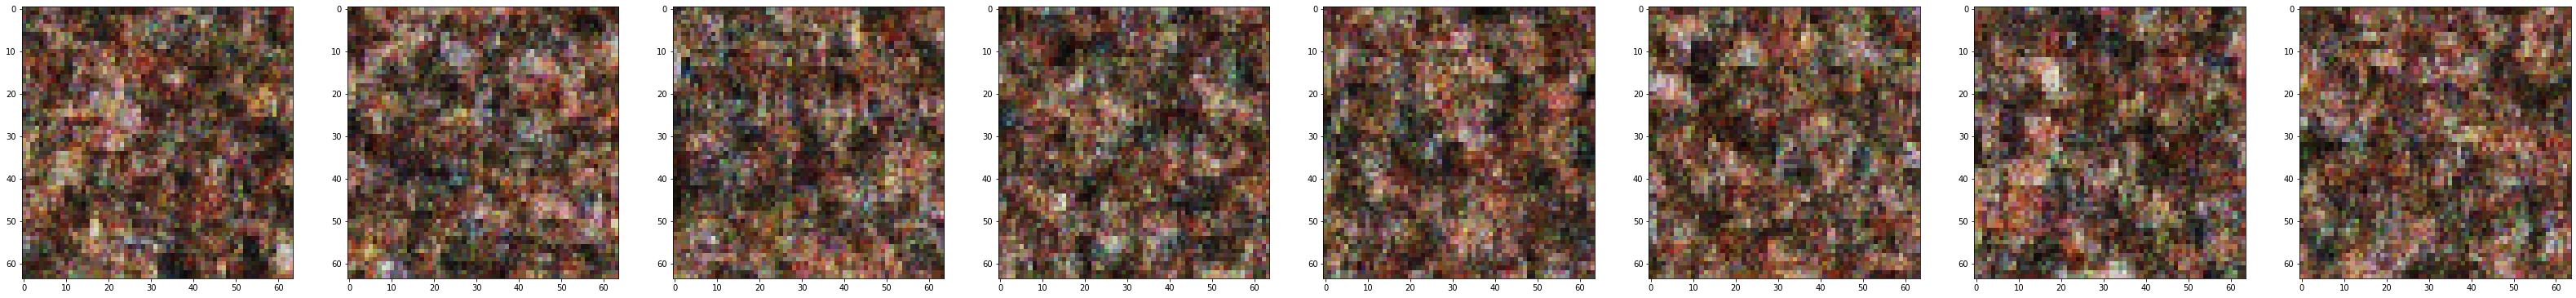

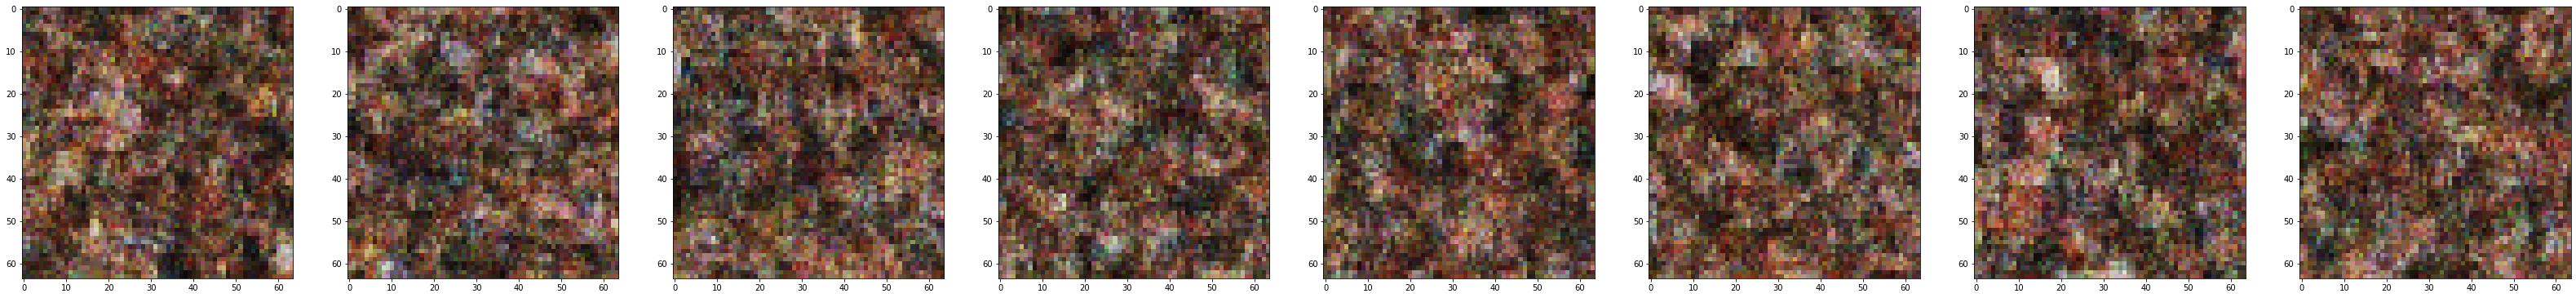

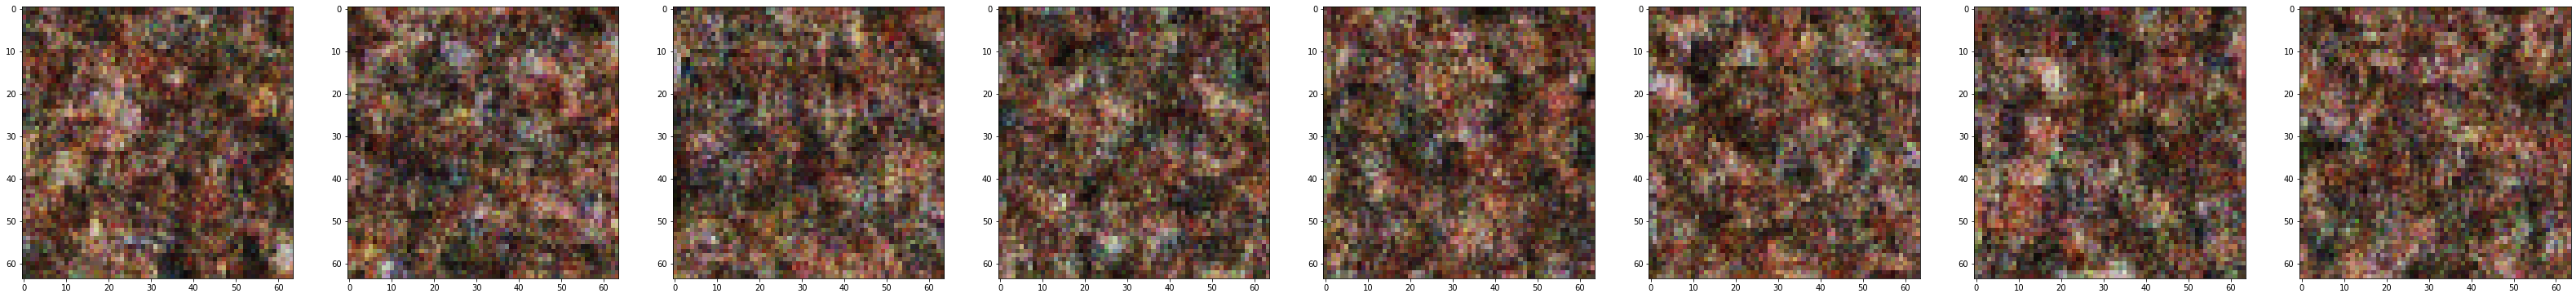

In [18]:
pbar = tqdm.notebook.tqdm(jnp.arange(10000))
inputs = {'x': None}
eval_key = random.PRNGKey(1)
for i in pbar:
    key, *keys = random.split(key, 3)
    x_batch = next(ds)['image']
    inputs = {'x': x_batch}
    
    # Take a gradient step
    params = get_params(opt_state)
    (val, state), grad = valgrad(params, state, inputs, key=keys[0])
    opt_state = opt_update(i, grad, opt_state)
    bits_per_dim = val/jnp.prod(x.shape)/jnp.log(2)
    
    pbar.set_description('bpd: %5.3f'%bits_per_dim)
    
    if(i%1000 == 0):
        k1, k2 = random.split(eval_key, 2)
        n_samples = 8

        # Sample from the latent state with some temperature
        z = random.normal(k1, (n_samples,) + flow.output_shapes['x'])

        # Invert the samples
        outputs, _ = flow.apply(params, state, {'x': z}, key=k2, sigma=0.0, reverse=True)
        fz = outputs['x']
    
        # Undo the dequantization and logit scaling to make sure we end up between 0 and 1
        fz /= (2.0**quantize_bits)
        fz *= (1.0 - 2*0.05) # This is the default scaling using in nux.Logit
        fz += 0.05

        # Plot the samples
        fig, axes = plt.subplots(1, n_samples, figsize=(7*n_samples, 7)); axes=axes.ravel()
        for i, ax in enumerate(axes):
            ax.imshow(fz[i])
        plt.show()